# Talktorial 7

# Ligand-based screening: machine learning

#### Developed in the CADD seminars 2017 and 2018, AG Volkamer, Charité/FU Berlin 

Jan Philipp Albrecht and Jacob Gora

## Aim of this talktorial

Due to larger available data sources, machine learning (ML) gained momentum in drug discovery and especially in ligand-based virtual screening. In this talktorial, we will learn how to use different supervised ML algorithms to predict the activity of novel compounds against our target of interest (EGFR).

## Learning goals

* Different fingerprints to encode the molecules for usage in ML
* Different ML algorithms and their application
* Evaluation of ML model performance

### Theory

* Introduce different types of fingerprints
* Different types of supervised ML algorithms
* Model performance evaluation and measurements 

### Practical

* Set up and evaluation of a ML-based screening pipeline for potential EGFR inhibitors

## References

* RdKit fingerprints, e.g. see [presentation by G. Landrum at rdkit UGM 2012](https://www.rdkit.org/UGM/2012/Landrum_RDKit_UGM.Fingerprints.Final.pptx.pdf):
* ML:
    * Random forest (RF): [http://ect.bell-labs.com/who/tkh/publications/papers/odt.pdf](http://ect.bell-labs.com/who/tkh/publications/papers/odt.pdf)
    * Support vector machines (SVM): [https://link.springer.com/article/10.1007%2FBF00994018](https://link.springer.com/article/10.1007%2FBF00994018)
    * Artificial neural networks (ANN): [https://www.frontiersin.org/research-topics/4817/artificial-neural-networks-as-models-of-neural-information-processing](https://www.frontiersin.org/research-topics/4817/artificial-neural-networks-as-models-of-neural-information-processing)
* Performance: 
    * [Sensitivity_and_specificity (wikipedia)](https://en.wikipedia.org/wiki/Sensitivity_and_specificity)
    * [Roc curve and AUC (wikipedia)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve)
* See also [git hub notebook by B. Merget](https://github.com/Team-SKI/Publications/tree/master/Profiling_prediction_of_kinase_inhibitors) from [*J. Med. Chem.*, 2017, 60, 474−485](https://pubs.acs.org/doi/10.1021/acs.jmedchem.6b01611) 

_____________________________________________________________________________________________________________________


## Theory

<img src="./images/ML_overview.png" width="200" align='right'>

To successfully apply ML, we need a large data set of molecules, a molecular encoding, a label per molecule in the data set, and a ML algorithm to train a model. Then, we can make predictions for new molecules.

### Data preparation

For ML, molecules need to be converted into a list of features. Often molecular fingerprints are used as representation. 

Fingerprints used in this talktorial and implemented in rdkit (more info can be found in a  [presentation by G. Landrum](https://www.rdkit.org/UGM/2012/Landrum_RDKit_UGM.Fingerprints.Final.pptx.pdf)):
* **maccs**: MACCS keys are 166 bit structural key descriptors in which each bit is associated with a SMARTS pattern.
* **ecfp4** and *ecfp6*: Extended-Connectivity Fingerprints (ECFPs) are circular topological fingerprints designed for molecular characterization, similarity searching, and structure-activity modeling. Most important parameters of ECFPs are maximum diameter and fingerprint length. The so called diameter specifies the maximum diameter of the circular neighborhoods considered for each atom. Here there are two diameters: 4 and 6. The length parameter specifies the length of the bit string representation. The default length is 2048.
* **torsion**: The Torsion Fingerprint Deviation (TFD) extracts, weights, and compares Torsion Fingerprints from a query molecule and generated conformations under consideration of acyclic bonds as well as ring systems.
* **rdk5**: rdk5 is a path based fingerprint. A path fingerprint is generated by exhaustively enumerating all linear fragments of a molecular graph up to a given size and then hashing these fragments into a fixed-length bit vector.

### Machine Learning (ML)

ML can be applied for (see also [scikit-learn page](http://scikit-learn.org/stable/)):

* **Classification (supervised)**: Identify to which category an object belongs (Nearest neighbors, Naive Bayes, RF, SVM, ...)
* Regression: Prediction of a continuous-values attribute associated with an object
* Clustering (unsupervised): Automated grouping of similar objects into sets (see **talktorial 5**)

#### Supervised learning

Learning algorithm creates rules by finding patterns in the training data. 
<img src="./images/RF_example.png" width="250" align='right'>
* **Random Forest (RF)**: Multiple decision trees which produce a mean prediction.

* **Support Vector Machines (SVM)**: SVMs can efficiently perform a non-linear classification using what is called the kernel trick, implicitly mapping their inputs into high-dimensional feature spaces. Classifier based on the idea of maximizing the margin as objective function.  

    <img src="./images/ANN_wiki.png" width="150" align='right'>
* **Artificial neural networks (ANNs)**: An ANN is based on a collection of connected units or nodes called artificial neurons which loosely model the neurons in a biological brain. Each connection, like the synapses in a biological brain, can transmit a signal from one artificial neuron to another. An artificial neuron that receives a signal can process it and then signal additional artificial neurons connected to it. (Figure from Wikipedia)
 
#### Validation strategy: K-fold cross validation

* This model validation technique splits the dataset in two groups in an iterative manner:
    * Training data set: Considered as the known dataset on which the model is trained
    * Test dataset: Unknown dataset on which the model is then tested
    * Process is repeated k-times
    
* The goal is to test the ability of the model to predict data which it has never seen before in order to flag problems known as over-fitting and to assess the generalization ability of the model.

#### Performance measures
<img src="./images/FP_TP_fig.png" width="250" align='right'>

* **Sensitivity**, also true positive rate: TPR = TP/(FN+TP)
* **Specificity**, also true negative rate: TNR = TN/(FP + TN)
* **Accuracy**, also the trueness: ACC = (TP + TN)/(TP + TN + FP + FN)
* **ROC-curve**, receiver operating characteristic curve
    * A graphical plot that illustrates the diagnostic ability of our classifier
    * Plots the sensitivity against the specificity
* **AUC**, the area under the roc curve (AUC):  
    * Describes the probability that a classifier will rank a randomly chosen positive instance higher than a negative one
    * Values between 0 and 1, the higher the better

In [30]:
# Import statements
# General:
import pandas as pd
import numpy as np

# rdkit:
from rdkit import Chem
from rdkit.Chem import RDKFingerprint
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem.AllChem import GetHashedTopologicalTorsionFingerprintAsBitVect
from rdkit.Chem import MACCSkeys
from rdkit.DataStructs import ConvertToNumpyArray

# sklearn:
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.manifold import TSNE
from sklearn.manifold import MDS

# matplotlib:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# seaborn:
import seaborn as sns

### Data preparation
We will work on EGFR (Epidermal growth factor receptor) kinase data for now.

But before starting, we will define two functions to help us creating the data frame we will work with.
The first method is named `calculate_fp` and calculates the molecular fingerprint of a molecule. The user has the choice between:
* maccs
* ecfp4 and ecfp6
* torsion
* rdk5 

In [2]:
def calculate_fp(mol, method='maccs', n_bits=2048):
    # mol = Chem molecule object
    # Function to calculate molecular fingerprints given the number of bits and the method
    if method == 'maccs':
        return MACCSkeys.GenMACCSKeys(mol)
    if method == 'ecfp4':
        return GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits, useFeatures=False)
    if method == 'ecfp6':
        return GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits, useFeatures=False)
    if method == 'torsion':
        return GetHashedTopologicalTorsionFingerprintAsBitVect(mol, nBits=n_bits)
    if method == 'rdk5':
        return RDKFingerprint(mol, maxPath=5, fpSize=1024, nBitsPerHash=2)

The second function helps us to create a data frame with the following additional columns:
* Our molecules as molecule objects (created SMILES-strings)
* The fingerprint as an python-object of the method of our choice (here MACCs)
* The bit-vector of the fingerprint method of our choice as binary representation

Therefore, we have two parameters: The data frame with a column named "smiles" with valid SMILES values, and the length of the fingerprint. The second argument is only used when others than MACCS fingerprint-method is chosen.

In [3]:
def create_mol(df_l, n_bits):
    # Construct a molecule from a SMILES string
    # Generate mol column: Returns a Mol object, None on failure.
    df_l['mol'] = df_l.smiles.apply(Chem.MolFromSmiles)
    # Create a column for storing the molecular fingerprint as fingerprint object
    df_l['bv'] = df_l.mol.apply(
        # Apply the lambda function "calculate_fp" for each molecule
        lambda x: calculate_fp(x, 'maccs', n_bits)
    )
    # Allocate np.array to hold fp bit-vector (np = numpy)
    df_l['np_bv'] = np.zeros((len(df_l), df_l['bv'][0].GetNumBits())).tolist()
    df_l.np_bv = df_l.np_bv.apply(np.array)
    # Convert the object fingerprint to NumpyArray and store in np_bv
    df_l.apply(lambda x: ConvertToNumpyArray(x.bv, x.np_bv), axis=1)

### Load data

Now let's start to load our data and to do the actual work. The *csv* file from **talktorial 2** is loaded into a dataframe with the important columns:

* the CHEMBL-ID
* the SMILES value of the corresponding compound
* pIC50

In [4]:
# Read data from previous talktorials
df = pd.read_csv('../data/T2/EGFR_compounds_lipinski.csv', delimiter=';', index_col=0)
# Look at head
print(df.shape)
print(df.info())

(4009, 10)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4009 entries, 0 to 4770
Data columns (total 10 columns):
molecule_chembl_id      4009 non-null object
units                   4009 non-null object
IC50                    4009 non-null float64
pIC50                   4009 non-null float64
smiles                  4009 non-null object
MW                      4009 non-null float64
HBA                     4009 non-null int64
HBD                     4009 non-null int64
LogP                    4009 non-null float64
rule_of_five_conform    4009 non-null object
dtypes: float64(4), int64(2), object(4)
memory usage: 344.5+ KB
None


### Classify data
We need to classify each compound as active or inactive, therefore, we use the pIC50 value. 
* pIC50 = -log10(IC50) 
* IC50 describes the molar concentration (mol/L) that will result in 50 percent of inhibition in-vitro. 
* A common cut-off value to discretize pIC50 data is 6,3, which we will use for our experiment.
* Note that there are several other suggestions for an activity cut-off ranging from an pIC50 value of 5 to 7 in the literature or even to define an exclusion range when not to take data points. 

Now we can use our functions defined above to generate our molecules and their fingerprints 
as well as specifying which molecule is active and which is not. 

In [5]:
# Drop unnecessary columns
df_new=df.drop(['units', 'IC50'], axis=1)
# Create molecules from smiles and their fingerprints
create_mol(df_new, 2048)
# Add column for activity
df_new['active'] = np.zeros(len(df_new))

# Mark every molecule as active with an pIC50 of > 6.3
df_new.loc[df_new[df_new.pIC50 >= 6.3].index, 'active'] = 1.0
print('actives: %d, inactives: %d' % (df_new.active.sum(), len(df_new)-df_new.active.sum()))

actives: 2181, inactives: 1828


In [6]:
df_new.head(3)

,molecule_chembl_id,pIC50,smiles,MW,HBA,HBD,LogP,rule_of_five_conform,mol,bv,np_bv,active
0,CHEMBL63786,11.522879,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,349.021459,3,1,5.2891,yes,<rdkit.Chem.rdchem.Mol object at 0x7f20102d9e40>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
1,CHEMBL53711,11.221849,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,343.043258,5,1,3.5969,yes,<rdkit.Chem.rdchem.Mol object at 0x7f20102d9e90>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
2,CHEMBL35820,11.221849,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,387.058239,5,1,4.9333,yes,<rdkit.Chem.rdchem.Mol object at 0x7f20102d9ee0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0


### Machine Learning (ML)

In the following we will try several ML approaches to classify our molecules. We will use:
* Random Forest (RF)
* Support Vector Machines (SVM) 
* Artificial Neural Networks (ANNs) 

Additionally, we will comment on the results. But before we start we define a function named `crossvalidation` which executes a cross validation procedure and returns measures such as accuracy, sensitivity and specificity.

The goal is to test the ability of the model to predict data which it has never seen before in order to flag problems known as overfitting and to assess the generalization ability of the model.

In [7]:
# Function for a cross-validation loop.
def crossvalidation(model_l, df_l, n_folds=10):
    # Given the selected model, the dataFrame and the number of folds the function executes a crossvalidation and returns
    # accuracy, sensitivity, specificity for the prediction as well as fpr, tpr, roc_auc for each fold
    
    # Empty results vector
    results = []
    # Shuffle the indices for the k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True)
    # Labels initialized with -1 for each data-point
    labels = -1 * np.ones(len(df_l))
    # Loop over the folds
    for train_index, test_index in kf.split(df_l):
        # Training
        # Convert the bit-vector and the label to a list
        train_x = df_l.iloc[train_index].bv.tolist()
        train_y = df_l.iloc[train_index].active.tolist()
        # Fit the model
        model_l.fit(train_x, train_y)

        # Testing
        # Convert the bit-vector and the label to a list
        test_x = df_l.iloc[test_index].bv.tolist()
        test_y = df_l.iloc[test_index].active.tolist()
        # Predict on test-set
        prediction_prob = model_l.predict_proba(test_x)[:, 1]
        # Save the predicted label of each fold
        labels[test_index] = model_l.predict(test_x)

        # Performance
        # Get fpr, tpr and roc_auc for each fold
        fpr_l, tpr_l, _ = roc_curve(test_y, prediction_prob)
        roc_auc_l = auc(fpr_l, tpr_l)
        # Append to results
        results.append((fpr_l, tpr_l, roc_auc_l))

    # Get overall accuracy, sensitivity, specificity
    y = df_l.active.tolist()
    acc = accuracy_score(df_l.active.tolist(), labels)
    sens = recall_score(df_l.active.tolist(), labels)
    spec = (acc * len(y) - sens * sum(y)) / (len(y) - sum(y))
    return acc, sens, spec, results


Of course we want to assess the quality of our models. Therefore we want to know the accuracy, sensitivity and specificity of our prediction. Additionally we focus on the so called ROC-curve. 

For reasons of clarity and comprehensibility of our code, we build a small function to plot our results. 

We will focus shortly on the following aspects:
* Sensitivity
* Specificity
* Accuracy
* ROC-curve and AUC

In [47]:
np.linspace(0.1, 1.0, 10)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [54]:
def print_results(acc, sens, spec, stat_res, main_text, plot_figure=1):
    plt.figure(plot_figure, figsize=(7, 7))
    cmap = cm.get_cmap('Blues')
    
    colors = [cmap(i) for i in np.linspace(0.3, 1.0, 10)]
    #colors = ["#3465A4"]
    for i, (fpr_l, tpr_l, roc_auc_l) in enumerate(stat_res):
        plt.plot(fpr_l, tpr_l, label='Area CV$_{0}$ = {1:0.2f}'.format(str(i),roc_auc_l), lw=2, color=colors[i])
        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random', lw=2, color="black")  # Random curve
    plt.xlabel('False positive rate', size=24)
    plt.ylabel('True positive rate', size=24)
    plt.title(main_text, size=24)
    plt.tick_params(labelsize=16)
    plt.legend(fontsize=16)
    
    # Save plot - use bbox_inches to include text boxes:
    # https://stackoverflow.com/questions/44642082/text-or-legend-cut-from-matplotlib-figure-on-savefig?rq=1
    plt.savefig("../data/T7/" + main_text.replace(" ", "_") + ".png", dpi=300, bbox_inches="tight", transparent=True)
    
    plt.show()
    # Calculate mean AUC and print
    m_auc = np.mean([elem[2] for elem in r[3]])
    print('Mean AUC: {}'.format(m_auc))

    # Show overall accuracy, sensitivity, specificity
    print('Sensitivity: {}\nAccuracy: {}\nSpecificity: {}\n'.format(acc, sens, spec))
    print('\n')

### Random forest classifier

Now we will start with a random forest classifier. We will first set the parameters. Afterwards we will do the cross validation of our model and plot the results. 

In [56]:
# Set model parameter for random Forest
param = {'max_features': 'auto',
         'n_estimators': 2000,
         'criterion': 'entropy',
         'min_samples_leaf': 1}
modelRf = RandomForestClassifier(**param)

# Do cross-validation procedure with 10 folds
r = crossvalidation(modelRf, df_new, 10)

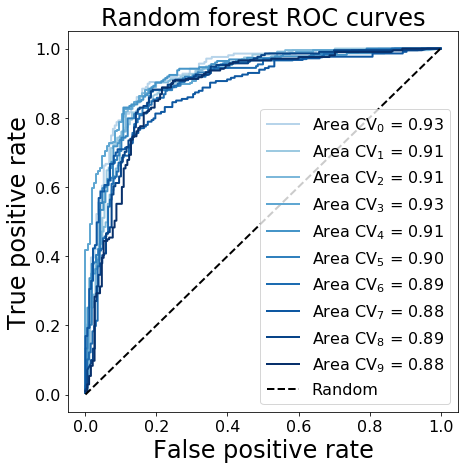

Mean AUC: 0.9027920475495419
Sensitivity: 0.8388625592417062
Accuracy: 0.8784961027051811
Specificity: 0.7915754923413567





In [57]:
# Plot the AUC results
# r contains acc, sens, spec, and results
print_results(r[0], r[1], r[2], r[3], 'Random forest ROC curves', 3)

Our models shows very good values for all measured values and, thus, seem to be predictive.

### Support vector classifier
Here we train a Support vector machine with a Radial-basis function kernel (also: squared-exponential kernel). 
For more information see [sklearn RBF kernel](http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RBF.html).

In [58]:
# Specify model
modelSvm = svm.SVC(kernel='rbf', C=1, gamma=0.1, probability=True)

# Do cross-validation procedure with 10 folds
r = crossvalidation(modelSvm, df_new, 10)

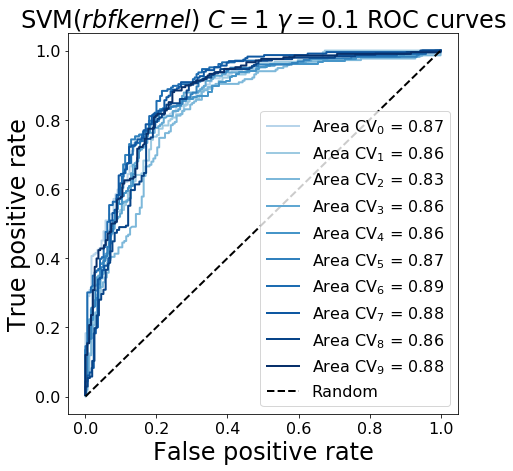

Mean AUC: 0.8659440471247365
Sensitivity: 0.8019456223497131
Accuracy: 0.8514442916093535
Specificity: 0.7428884026258206





In [62]:
# Plot results
print_results(r[0], r[1], r[2], r[3],
              'SVM$(rbf kernel)$ $C=1$ $\gamma=0.1$ ROC curves', 3)

### Neural network classifier
The last approach we try here is a neural network model. We train an MLPClassifier (Multi-layer Perceptron classifier) with 3 layers, each with 5 neurons. You may notice early stopping is explicitely set to FALSE. As before, we do the crossvalidation procedure and plot the results. For more infor on MLP, see [sklearn MLPClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html).

In [60]:
# Specify model, default activation: relu
modelClf = MLPClassifier(solver='adam', 
                         alpha=1e-5, 
                         hidden_layer_sizes=(5, 3), 
                         random_state=1, early_stopping=False)

# Do cross-validation procedure with 10 folds
r = crossvalidation(modelClf, df_new, 10)

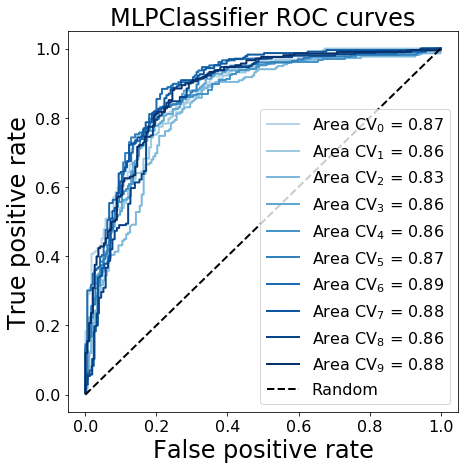

Mean AUC: 0.8659440471247365
Sensitivity: 0.8019456223497131
Accuracy: 0.8514442916093535
Specificity: 0.7428884026258206





In [61]:
# Plot results
print_results(r[0], r[1], r[2], r[3], 'MLPClassifier ROC curves', 3)

## Discussion

* Which model performed best on our data set and why?
    * All three models perform (very) good on our dataset. The best models are the random forest and support vector machine models which showed a mean AUC of 90%. Our neuronal network showed slightly lower results with a mean AUC of 87%. (Note values can slightly differ if you rerun the script.)
    * There might be several reasons that the random forest and support vector machine models performed best. Our dataset might be easily separable in active/inactive with some simple tree-like decisions or with the radial basis function, respectively. Thus, there is not such a complex pattern in the fingerprints to do this classification.
    * A cause for the slightly poorer performance of the ANN, could be that there was simply too few data to train the model on.
    * Additionally, it is always advisable to have another external validation set for model evaluation.
    
* Was MACCS the right choice?
    * Obviously, MACCS was good to start training and validating models to see if a classification is possible. 
    * But since MACCS fingerprints are rather short (166 bit) compared to others (2048 bit), one should try different fingerprints and repeat the validation process.

    
### Where can we go from here?

* We successfully trained several models. 
* The next step is to use these models to do a classification with an unknown screening dataset to predict novel potential EGFR inhibitors.
* An example for a large screening data set is e.g. [MolPort](https://www.molport.com/shop/database-download) with over 7 million compounds.
* Our models could be used to rank the MolPort compounds and then further study those with the highest predicted probability of being active.
* For an application of such see also the [TDT Tutorial](https://github.com/sriniker/TDT-tutorial-2014) developed by S. Riniker and G. Landrum, where they trained a fusion model to screen [eMolecules](https://www.emolecules.com/) for new anti-malaria drugs.

### Quiz

* How can you apply ML for virtual screening?
* Which machine learning algorithms do you know?
* What are necessary prerequisites to successfully apply ML?